<a href="https://colab.research.google.com/github/ebest3/tda_ai_text_generation/blob/main/tda_ai_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/aguilin1/tda_ai_text_generation.git

Cloning into 'tda_ai_text_generation'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 317 (delta 4), reused 2 (delta 2), pack-reused 303 (from 1)
Receiving objects: 100% (317/317), 96.94 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (155/155), done.
Updating files: 100% (70/70), done.


In [2]:
!pip install nltk
!pip install Ripser
!pip install gudhi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.9 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=5140c86f0e412aae51a6c18d184443d503c9ebc219edbed6735f2ef863e6c9a4
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 38.9 MB/s eta 0:00:00


In [3]:
# set up imports

import itertools
import warnings
import sys
import pickle
import copy
import gudhi as gd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from ripser import ripser, Rips
from persim import plot_diagrams, PersImage, PersistenceImager
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from scipy.sparse import SparseEfficiencyWarning

np.set_printoptions(threshold=sys.maxsize)

In [4]:
warnings.simplefilter('ignore',SparseEfficiencyWarning)

# Based on method from "A Novel Method of Extracting Topological Features from Word Embeddings" https://arxiv.org/pdf/2003.13074v2
def smoothing(embeddings):
  number_sentences = embeddings.shape[0]
  original_embeddings = embeddings.copy()
  for i in range(number_sentences):
    smoothed = original_embeddings[safe_index(i -1, number_sentences)]/2.0 + \
      original_embeddings[i] + \
      original_embeddings[safe_index(i +1, number_sentences)]/2.0
    embeddings[i] = smoothed
  return embeddings

def safe_index(i, total_n):
  if i < 0:
    return i * -1
  elif i >= total_n-1:
    return total_n -1 - (i % total_n)
  else:
    return i


# See paper for proof this is a metric
def angular_distance(embeddings, index_1, index_2):
  cos_sim = cosine_similarity(embeddings[index_1].reshape(1, -1),\
                              embeddings[index_2].reshape(1, -1))[0][0]

  # If we've gotten here it's likely the precision needed to differentiate is more than a float can handle
  if cos_sim > 1:
    cos_sim = 1.0
  elif cos_sim < 0:
    cos_sim = 0
  dist = 2 * np.arccos(cos_sim) / np.pi

  # The coersion above should make this not necessary, but to be safe
  if np.isnan(dist):
    dist = 0.0
  return dist


# The time skeleton is based on the method from "Persistent Homology: An Introduction and a New Text Representation for Natural Language Processing"
# https://www.ijcai.org/Proceedings/13/Papers/288.pdf
def angular_distance_matrix(embeddings, time_skeleton = False):
  # get # of data points in each sample
  n_dpts = embeddings.shape[0]
  # preallocate distance matrix
  angular_distances = np.zeros((n_dpts, n_dpts))
  # Label each data point in order starting at 0, 1, 2, ...
  # Distance between data point i and data point j is in (i,j) entry of matrix
  # Matrix will be upper triangular
  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      dist = angular_distance(embeddings, pair1_i, pair2_i)
    angular_distances[pair1_i][pair2_i] = dist
    angular_distances[pair2_i][pair1_i] = dist
  return angular_distances

# This aligns with the "experimental composite metric" from the paper
def mixed_distance_matrix(bow_embeddings, bert_embeddings, alpha, time_skeleton = False):
  # This should align with the tokens (number of sentences), so match between types
  n_dpts = bert_embeddings.shape[0]

  cosSimDistances = np.zeros((n_dpts, n_dpts))

  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      distance_bow = angular_distance(bow_embeddings, pair1_i, pair2_i)
      distance_bert = angular_distance(bert_embeddings, pair1_i, pair2_i)
      dist = alpha * distance_bow + (1 - alpha) * distance_bert

    cosSimDistances[pair1_i][pair2_i] = dist
    cosSimDistances[pair2_i][pair1_i] = dist
  return cosSimDistances


# input a symmetric distance matrix and this function will return birth and
# death homology data for the V-R complex
def ripserFiltration(distanceMat, maxDim=3):
  # Here's one way to use Ripser
  # examples and instructions are here:
  # https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
  # https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix

  # This version uses the distance matrix input, which is what we want
  #plotDistanceHistogram(distanceMat)
  birthDeathPairs = ripser(distanceMat, distance_matrix=True, maxdim=maxDim, do_cocycles=True)['dgms']

  # diagrams is a vector of vectors where each element of each
  # vector is [birth epoch, death epoch] and the vectors are in increasing order
  # of homology (H0, H1, H2, etc.).
  return birthDeathPairs

# Get a visual histogram to see the distance spread
def plotDistanceHistogram(distmatrix):
  # Flatten the matrix to get all data in a single array
  data = [x for x in distmatrix.flatten() if x != 0]
  # Create the histogram
  plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
  # Add titles and labels
  plt.title('Histogram of Distances')
  plt.xlabel('Distance')
  plt.ylabel('Frequency')
  # Show the plot
  plt.show()
  # we need a way to figure out which metric was used for this plot

In [5]:
# Python implementation of Vietoris Rips filtration

# Simplex is conceptually a set of vertices
class Simplex(frozenset):
    def __str__(self):
        return ",".join(str(item) for item in self)

    def __repr__(self):
        return f"({', '.join(repr(item) for item in self)})"

    def __or__(self, other):
        return Simplex(super().__or__(other))

    def union(self, *others):
        return Simplex(super().union(*others))

    def __and__(self, other):
        return Simplex(super().__and__(other))

    def intersection(self, *others):
        return Simplex(super().intersection(*others))

    def __sub__(self, other):
        return Simplex(super().__sub__(other))

    def difference(self, *others):
        return Simplex(super().difference(*others))

    def __xor__(self, other):
        return Simplex(super().__xor__(other))

    def symmetric_difference(self, other):
        return Simplex(super().symmetric_difference(other))

    def dimension(self):
        return len(self)

# Computes angular distance for each sentence pair in the given data
def distances(embeddings, time_skeleton):
    distances = {}
    for pair1, pair2 in itertools.combinations(range(embeddings.shape[0]), 2):
      if (pair1 == pair2 + 1 or pair1 == pair2 - 1) and time_skeleton:
        dist = 0
      else:
        dist = angular_distance(embeddings, pair1, pair2)
      distances[Simplex([pair1, pair2])] = dist
    return distances

# Generates the simplices from the distances
def simplicies(data):
    points = set(itertools.chain.from_iterable(data))
    p = points.copy()
    complexes_by_distance = {
        0.0: set([Simplex([a]) for a in p])
    }
    for simplex, distance in data.items():
      if distance not in complexes_by_distance:
          complexes_by_distance[distance] = set()
      complexes_by_distance[distance].add(simplex)

    # 3 dimension: triangles where the edges are all within the given distance
    for v1,v2,v3 in itertools.combinations(p, 3):
        edges = [Simplex(x) for x in itertools.combinations([v1, v2, v3], 2)]
        distance = max(data[edge] for edge in edges)
        complexes_by_distance[distance].add(Simplex([v1, v2, v3]))

    # 4 dimension: tetrahedra where edges are all within the given distance
    for v1,v2,v3,v4 in itertools.combinations(points, 4):
        edges = [Simplex(x) for x in itertools.combinations([v1, v2, v3, v4], 2)]
        distance = max(data[edge] for edge in edges)
        complexes_by_distance[distance].add(Simplex([v1, v2, v3, v4]))

    return complexes_by_distance

# Runs the Vietoris Rips filtration and returns different information on persistence
def filtration(distances, max_distance, debug = False):
    homologies_births = {}
    homologies_per_epic = {}

    if debug:
      print("\t Computing simplices")
    simplices_by_distance = simplicies(distances)
    # Add the zero homologies to the first epic by default
    for points in distances.keys():
        for point in points:
            homologies_births[Simplex([point])] = 0
    homologies_per_epic[0] = set(homologies_births.keys()) | simplices_by_distance[0.0]

    if max_distance == 'inf':
        max_distance = max(distances.values())

    birth_deaths = []

    for current_distance_filter in sorted(distances.values()):
        if current_distance_filter > max_distance:
            break

        new_in_epic = simplices_by_distance[current_distance_filter]
        homologies_per_epic[current_distance_filter] = new_in_epic

        for item in new_in_epic:
            homologies_births[item] = current_distance_filter

    sorted_simplices = matrix_sorted_values(homologies_per_epic, current_distance_filter)
    matrix = evaluation_matrix(sorted_simplices)

    if debug:
        print(sorted_simplices)
        debug_matrix = reconstruct_matrix(matrix)
        print(debug_matrix)
        print(np.count_nonzero(np.matmul(debug_matrix,debug_matrix) % 2))
        print("\t Running persistence algorithm")

    deaths, homologies, pivots, chain_members = evaluate(matrix, sorted_simplices)

    if debug:
        debug_matrix = reconstruct_matrix(matrix)
        print(debug_matrix)

    birth_deaths_by_dim = {i: [] for i in range(4)}
    for death, killed_by in deaths.items():
        birth = homologies_births.pop(death, None)
        death_epic = homologies_births[killed_by]

        index = sorted_simplices.index(death)
        birth_deaths.append((homologies[index], birth, death_epic))

        homology = homologies[index]
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        birth_deaths_by_dim[dimension].append([birth, death_epic])

    still_living = []
    for still_living_homology, birth in homologies_births.items():
        if still_living_homology in chain_members:
            continue
        still_living.append((still_living_homology, birth, None))
        homology = still_living_homology
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        birth_deaths_by_dim[dimension].append([birth, np.inf])

    return birth_deaths, still_living, current_distance_filter, {i: np.array(p) for i,p in birth_deaths_by_dim.items()}

# Filtrations sorted within each epic for use as rows/columns of our matrix
def matrix_sorted_values(filtration_by_epic, current_epic):
    sorted_by_epic = []
    for epic in sorted(filtration_by_epic.keys()):
        homologies = filtration_by_epic[epic]
        if len(homologies) > 0:
            sorted_by_epic += sorted(homologies, key = lambda homology: homology.dimension())

    return sorted_by_epic

# Since this is very sparse we're not really making a matrix, but one can be reconstructed
# from the hash output here
def evaluation_matrix(sorted_filtration):
    index_lookup = {h: i for i, h in enumerate(sorted_filtration)}
    matrix = {}

    for j, complex in enumerate(sorted_filtration):
        if complex.dimension() == 1:
            continue
        for member in complex:
            boundary = complex ^ Simplex([member])
            i = index_lookup[boundary]
            if j in matrix:
                matrix[j].add(i)
            else:
                matrix[j] = set([i])
    return matrix

# Reconstruct the matrix for debugging
def reconstruct_matrix(matrix_base):
    n = max(matrix_base.keys()) + 1
    matrix = np.zeros((n,n), dtype=np.int8)

    for col, row_markers in matrix_base.items():
        for row in row_markers:
            matrix[row, col] = 1

    return matrix

# Run the persistence algorithm from "Computing Persistent Homology" https://graphics.stanford.edu/courses/cs233-24-winter-v1/ReferencedPapers/Computing%20Persistent%20Homology%20zc-cph-05.pdf
def evaluate(matrix, orig_values):
    deaths = {}
    pivot_to_column = {}
    values = {i: {homology} for i, homology in enumerate(orig_values)}

    members_of_chain = set()
    for column in range(len(orig_values)+1):
        while True:
            if column in matrix.keys():
                column_row_nonzeros_indices = matrix[column]
                if len(column_row_nonzeros_indices) == 0:
                    break

                lowest_nonzero = max(column_row_nonzeros_indices)
                if lowest_nonzero in pivot_to_column.keys():
                    previous_pivot_column = pivot_to_column[lowest_nonzero]
                    previous_pivot_row = matrix[previous_pivot_column]
                    matrix[column] = column_row_nonzeros_indices ^ previous_pivot_row
                    values[column].update(values[previous_pivot_column])
                else:
                    pivot_to_column[lowest_nonzero] = column
                    for val in values[lowest_nonzero]:
                        if val != orig_values[lowest_nonzero]:
                            members_of_chain.add(val)
                    deaths[orig_values[lowest_nonzero]] = orig_values[column]
                    break
            else:
                break

    return deaths, values, pivot_to_column, members_of_chain

In [6]:
# Load the pre-computed embeddings stored in github
def load_cached_embeddings(abstract_type, embedding_type, num_abstracts):
  DATA_FILE_BASE = '/content/tda_ai_text_generation/data/{}_encodings_{}-{}.pkl'

  if embedding_type == 'bert':
    batch_sentences = []
    batch_embeddings = []
    for i in range(0,num_abstracts,100):
      i += 1
      bert_data = DATA_FILE_BASE.format('sentence-bert', abstract_type, i)
      with open(bert_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences += cache_data['sentences']
        batch_embeddings += cache_data['embeddings']
  elif embedding_type == 'bow':
    batch_sentences = []
    batch_embeddings = []
    for i in range(0,num_abstracts,500):
      bow_data = DATA_FILE_BASE.format('bow', abstract_type, i)
      with open(bow_data, "rb") as data_file:
          cache_data = pickle.load(data_file)
          batch_sentences += cache_data['sentences']
          batch_embeddings += cache_data['embeddings']
  return batch_sentences, batch_embeddings

In [7]:
# Plot persistence diagram using plotly where the points show the actual chain on hover
def plot_persistence_diagram_b(births_deaths, still_living, max_epic):
    colors = {
        0: 'purple',
        1: 'cornflowerblue',
        2: 'green',
        3: 'yellow'
    }

    seen_dim = set()
    infinity_val = max_epic * 1.09
    graph_edge = max_epic * 1.1

    data = []

    for persistence in births_deaths + still_living:
        homology = persistence[0]
        if isinstance(homology, set):
            dimension = list(homology)[0].dimension() - 1
        else:
            dimension = homology.dimension() - 1
        if dimension > 2:
            continue
        birth = persistence[1]
        death = persistence[2] if persistence[2] is not None else infinity_val
        # if birth == death:
        #     continue

        label = f"H{dimension}" if dimension not in seen_dim else None
        seen_dim.add(dimension)

        data.append(go.Scatter(
            x=[birth],
            y=[death],
            mode='markers',
            marker=dict(color=colors.get(dimension, 'black'), size=8),
            name=label if label else f"H{dimension}",
            showlegend=(label is not None),
            text=str(homology)
        ))

    data.append(go.Scatter(
        x=[0, graph_edge],
        y=[0, graph_edge],
        mode='lines',
        line=dict(color='gray', dash='dash'),
        name='Diagonal'
    ))

    data.append(go.Scatter(
        x=[0, graph_edge],
        y=[infinity_val, infinity_val],
        mode='lines',
        line=dict(color='gray', dash='dash'),
        name='Infinity'
    ))

    layout = go.Layout(
        title=f"Persistence Diagram",
        xaxis=dict(title='Birth', range=[0, graph_edge]),
        yaxis=dict(title='Death', range=[0, infinity_val * 1.1]),
        legend=dict(itemsizing='constant'),
        width=600,
        height=600
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [8]:
import pprint

sentences, batch_embeddings = load_cached_embeddings('ai', 'bow', 10)
index = 7
d = distances(batch_embeddings[index], False)

birth_deaths, still_living, max_epic, dims = filtration(d, 'inf')
plot_persistence_diagram_b(birth_deaths, still_living, max_epic)
pprint.pp({i: sentence for i,sentence in enumerate(sentences[index])})


{0: 'The open cluster, NGC 3680, has been of interest to many astronomers due '
    'to its intermediate age and proximity to the Sun.',
 1: 'Recently, lithium has also emerged as a topic of great interest within '
    'the cluster.',
 2: 'Here, we present a detailed analysis of the lithium abundance of NGC 3680 '
    'stars using high-resolution spectra obtained with the Fibre-fed Extended '
    'Range Optical Spectrograph (FEROS) at the La Silla Observatory.',
 3: 'Our sample comprises 80 stars within the cluster, with effective '
    'temperatures ranging from 4900 K to 6800 K and atmospheric pressures of '
    '1.5 to 4.0 dex.',
 4: 'We find no significant correlation between the effective temperature and '
    'the lithium abundance of the stars.',
 5: 'However, we do observe a negative correlation between the lithium '
    'abundance and the stellar age, which indicates that the depletion of '
    'lithium is due to post-main sequence depletion.',
 6: 'Furthermore, we find that t

In [47]:
# Evaluation pipeline

# Collects the size of the homologies that do not immediately die
def diagram_sizes(dgms):
    return {f"H_{i}": len([p for p in d if p[0] != p[1]]) for i, d in enumerate(dgms)}

# Prints the average size of the homologies for a batch of abstracts
def print_sizes(sizes, num_abstracts):
  num_h0 = 0
  num_h1 = 0
  num_h2 = 0
  for size in sizes:
    num_h0 += size['H_0']
    num_h1 += size['H_1']
    num_h2 += size['H_2']

  print("|H0|: {} |H1|: {} |H2|: {}".format(num_h0/num_abstracts, num_h1/num_abstracts, num_h2/num_abstracts))

# Replaces infinity with an arbitrarily large value
def replace_infinity(diagrams, replace_with = 1.1):
  for diagram in diagrams:
    for point in diagram:
      if point[1] == np.inf:
        point[1] = replace_with
  return diagrams

# Remove elements that have not died by the end of the filtration
def remove_infinity(diagram):
  for dim in range(len(diagram)):
    if len(diagram[dim]) > 0:
      diagram[dim] = diagram[dim][~np.any(diagram[dim] == np.inf, axis=1)]
  return diagram

# For the given parameter set, run the filtration on the embeddings, optionally plot the persistence diagrams,
# and return the persistence diagrams by dimension as well as initialized classification vectors for regression analysis
def run_evaluation(abstract_type, embedding_type, time_skeleton = False, with_smoothing = False, graph = False, num_abstracts = 100):
  _, batch_embeddings = load_cached_embeddings(abstract_type, embedding_type, num_abstracts)

  # initialize diagram arrays
  diagrams_h0 = []
  diagrams_h1 = []
  diagrams_h2 = []

  rips = Rips()
  persistence_diagrams = []
  sizes = []
  description = "{} text embedding from {}".format(abstract_type, embedding_type.upper())
  if time_skeleton:
    description += " with time skeleton"
  if with_smoothing:
    description += " smoothed"
  if graph:
    num_abstracts = 3
    fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(9,6))
    title = "Persistence diagram for {}".format(description)
    fig.suptitle(title)
    subplot = 0
  else:
    print(description)

  for i, embeddings in enumerate(batch_embeddings[0:num_abstracts]):
    if embeddings.shape[0] < 5:
      continue
    if with_smoothing:
      embeddings = smoothing(embeddings)

    d = distances(embeddings, time_skeleton)
    birth_deaths, still_living, max_epic, bd = filtration(d, 'inf')
    diagram = list(bd.values())

    # distances = angular_distance_matrix(embeddings, time_skeleton)
    # diagram = ripserFiltration(distances)
    persistence_diagrams.append(diagram)
    sizes.append(diagram_sizes(diagram))
    # instantiate PeristanceImager to use in plotting
    pimgr = PersistenceImager(pixel_size=0.05, kernel_params = {'sigma': .005})
    # pimgr.fit(replace_infinity(diagram))

    if graph:
      PIdim = 1
      img = pimgr.transform(remove_infinity(diagram)[PIdim])
      pimgr.plot_image(img, ax=axs[1][subplot])
      rips.plot(diagram[:-1], show=False, ax=axs[0][subplot])
      subplot += 1

    # For each new diagram, append its points to the the appropriate array. These must have all infs removed or replaced.
    #diagram_infResolved = replace_infinity(diagram)
    diagram_infResolved = remove_infinity(diagram)
    # skip any empty ones
    if len(diagram_infResolved[0]) > 0:
      diagrams_h0.append(diagram_infResolved[0])
    if len(diagram_infResolved[1]) > 0:
      diagrams_h1.append(diagram_infResolved[1])
    if len(diagram_infResolved[2]) > 0:
      diagrams_h2.append(diagram_infResolved[2])

  # create labels array for regression analysis later--all zeros for ai, all ones for human
  if abstract_type == 'ai':
    labelsH0 = np.zeros(len(diagrams_h0))
    labelsH1 = np.zeros(len(diagrams_h1))
    labelsH2 = np.zeros(len(diagrams_h2))
  else:
    labelsH0 = np.ones(len(diagrams_h0))
    labelsH1 = np.ones(len(diagrams_h1))
    labelsH2 = np.ones(len(diagrams_h2))
  if graph:
    plt.show()

  print_sizes(sizes, num_abstracts)

  return persistence_diagrams, diagrams_h0, diagrams_h1, diagrams_h2, labelsH0, labelsH1, labelsH2

# Runs the same process as above but using the experimental composite metric
def run_mixed_encoding_evaluation(abstract_type, alpha, num_abstracts=6, time_skeleton = False, graph=False):
  _, batch_bow_embeddings = load_cached_embeddings(abstract_type, 'bow', num_abstracts)
  _, batch_bert_embeddings = load_cached_embeddings(abstract_type, 'bert', num_abstracts)

  if alpha < 0.0 and alpha > 1.0:
    raise ValueError("alpha must be between 0 and 1")

  diagrams_h0 = []
  diagrams_h1 = []
  diagrams_h2 = []

  rips = Rips(do_cocycles=True)
  persistence_diagrams = []
  sizes = []
  description = "{} mixed embeddings with alpha={}".format(abstract_type, alpha)
  if time_skeleton:
    description += " with time skeleton"
  if graph:
    num_abstracts = 3
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
    title = "Persistence diagrams for {}".format(description)
    fig.suptitle(title)
    subplot = 0
  else:
    print(description)
  for i in range(num_abstracts):
    pimgr = PersistenceImager(pixel_size=0.05)
    distances = mixed_distance_matrix(batch_bow_embeddings[i], batch_bert_embeddings[i], alpha, time_skeleton)
    diagram = ripserFiltration(distances)
    persistence_diagrams.append(diagram)
    sizes.append(diagram_sizes(diagram))

    if graph:
      rips.plot(diagram[:-1], show=False, ax=axs[subplot])
      subplot += 1

    # For each new diagram, append its points to the the appropriate array. These must have all infs removed or replaced.
    #diagram_infResolved = replace_infinity(diagram)
    diagram_infResolved = remove_infinity(diagram)
    # skip any empty ones
    if len(diagram_infResolved[0]) > 0:
      diagrams_h0.append(diagram_infResolved[0])
    if len(diagram_infResolved[1]) > 0:
      diagrams_h1.append(diagram_infResolved[1])
    if len(diagram_infResolved[2]) > 0:
      diagrams_h2.append(diagram_infResolved[2])

  if graph:
    plt.show()

  if abstract_type == 'ai':
    labelsH0 = np.zeros(len(diagrams_h0))
    labelsH1 = np.zeros(len(diagrams_h1))
    labelsH2 = np.zeros(len(diagrams_h2))
  else:
    labelsH0 = np.ones(len(diagrams_h0))
    labelsH1 = np.ones(len(diagrams_h1))
    labelsH2 = np.ones(len(diagrams_h2))

  print_sizes(sizes, num_abstracts)
  return persistence_diagrams, diagrams_h0, diagrams_h1, diagrams_h2, labelsH0, labelsH1, labelsH2

# Gets the persistence diagrams from above, converts to persistence images, and performs regression analysis on the results
def evaluation(embedding_type, time_skeleton = False, with_smoothing = False, alpha = 0.5, num_abstracts = 100):
  # initialize arrays to hold data for both the ai and human cases
  labelsH0_actual = []
  labelsH1_actual = []
  labelsH2_actual = []
  diagrams_h0_actual = []
  diagrams_h1_actual = []
  diagrams_h2_actual = []

  if embedding_type == 'mixed':
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_mixed_encoding_evaluation('ai', alpha, time_skeleton=time_skeleton, graph=False, num_abstracts=num_abstracts)
  else:
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_evaluation('ai', embedding_type, time_skeleton=time_skeleton, with_smoothing=with_smoothing, graph=False, num_abstracts=num_abstracts)

  # add ai run data to holding arrays
  labelsH0_actual.extend(lblH0)
  labelsH1_actual.extend(lblH1)
  labelsH2_actual.extend(lblH2)
  diagrams_h0_actual.extend(dH0)
  diagrams_h1_actual.extend(dH1)
  diagrams_h2_actual.extend(dH2)

  if embedding_type == 'mixed':
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_mixed_encoding_evaluation('human', alpha, time_skeleton=time_skeleton, graph=False, num_abstracts=num_abstracts)
  else:
    _, dH0, dH1, dH2, lblH0, lblH1, lblH2 = run_evaluation('human', embedding_type, time_skeleton=time_skeleton, with_smoothing=with_smoothing, graph=False, num_abstracts=num_abstracts)

  # add human run data to holding arrays
  labelsH0_actual.extend(lblH0)
  labelsH1_actual.extend(lblH1)
  labelsH2_actual.extend(lblH2)
  diagrams_h0_actual.extend(dH0)
  diagrams_h1_actual.extend(dH1)
  diagrams_h2_actual.extend(dH2)

  title = "Persistence images for {} encodings".format(embedding_type)
  if embedding_type == 'mixed':
    title += " with alpha={}".format(alpha)
  if with_smoothing:
    title += " smoothed"
  if time_skeleton:
    title += " with time skeleton"
  fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(6,3))
  fig.suptitle(title)
  # transform peristence diagrams into persistence images and generate flat vector versions of the PIs for user in regression
  # for H0, all the birth values are 0. This is specially handled by duplicating all the pairs and setting the duplicate birth values to 1 so that there is a 2-dimensionality in the resulting diagram
  if len(diagrams_h0_actual) > 0:
    # extend H0 to avoid error when all births are zero
    d = copy.deepcopy(diagrams_h0_actual)
    l = copy.deepcopy(labelsH0_actual)
    # It looks like we don't need this if we're not fitting
    # for diag in d:
    #   diag[:,0]=1
    diagrams_h0_actual.extend(d)
    labelsH0_actual.extend(l)
    # instantiate PersistenceImager, transform PD to PI, and flatten everything for regression analysis
    pimgrH0 = PersistenceImager(pixel_size=0.05, kernel_params = {'sigma': [[0.00001, 0.0], [0.0, 0.001]]}) # set x variance very very small to make this distribution almost univariate (the H0 distribution is univariate)
    # pimgrH0.fit(diagrams_h0_actual). Adjust y variance as desired for tuning.
    imgsH0 = pimgrH0.transform(diagrams_h0_actual, skew=False)
    imgsH0_array = np.array([imgH0.flatten() for imgH0 in imgsH0])
    cutoff_mid = len(imgsH0) // 2
    average_imgsH0_ai = sum(imgsH0[:cutoff_mid])/len(imgsH0)
    average_imgsH0_human = sum(imgsH0[cutoff_mid:])/len(imgsH0)
    pimgrH0.plot_image(average_imgsH0_ai, axs[0][0])
    # ELI add
    # print(average_imgsH0_ai)
    # plt.imshow(average_imgsH0_ai, cmap='hot', interpolation='nearest')
    # plt.show()
    # End ELI add
    pimgrH0.plot_image(average_imgsH0_human, axs[1][0])
  # for H1
  if len(diagrams_h1_actual) > 0:
    # instantiate PersistenceImager, transform PD to PI, and flatten everything for regression analysis
    pimgrH1 = PersistenceImager(pixel_size=0.05, kernel_params = {'sigma': .001})
    # pimgrH1.fit(diagrams_h1_actual)
    imgsH1 = pimgrH1.transform(diagrams_h1_actual, skew=True)
    imgsH1_array = np.array([imgH1.flatten() for imgH1 in imgsH1])
    cutoff_mid = len(imgsH1) // 2
    average_imgsH1_ai = sum(imgsH1[:cutoff_mid])/len(imgsH1)
    average_imgsH1_human = sum(imgsH1[cutoff_mid:])/len(imgsH1)
    pimgrH1.plot_image(average_imgsH1_ai, axs[0][1])
    pimgrH1.plot_image(average_imgsH1_human, axs[1][1])
  # for H2
  if len(diagrams_h2_actual) > 0:
    # instantiate PersistenceImager, transform PD to PI, and flatten everything for regression analysis
    pimgrH2 = PersistenceImager(pixel_size=0.05, kernel_params = {'sigma': .001})
    # pimgrH2.fit(diagrams_h2_actual)
    imgsH2 = pimgrH2.transform(diagrams_h2_actual, skew=True)
    imgsH2_array = np.array([imgH2.flatten() for imgH2 in imgsH2])
    cutoff_mid = len(imgsH2) // 2
    average_imgsH2_ai = sum(imgsH2[:cutoff_mid])/len(imgsH2)
    average_imgsH2_human = sum(imgsH2[cutoff_mid:])/len(imgsH2)
    pimgrH2.plot_image(average_imgsH2_ai, axs[0][2])
    pimgrH2.plot_image(average_imgsH2_human, axs[1][2])

  plt.show()

  # Perform regression analysis on all dimensions
  if len(diagrams_h0_actual) > 0:
    # split out testing and training cases
    X0_train, X0_test, y0_train, y0_test = train_test_split(imgsH0_array, labelsH0_actual, train_size=0.80, random_state=42)

    # linear regression approach
    lrH0 = LogisticRegression()
    lrH0.fit(X0_train, y0_train)
    scr0 = lrH0.score(X0_test, y0_test)
    pred0 = lrH0.predict(X0_test)
    print('H0: Linear regression classification score was', scr0)

    # binning approach
    pred0bin = np.zeros(len(X0_test))
    # sum and normalize class representative distributions
    imgsH0_ai_classrep = sum(X0_train[y0_train == np.float64(0)]) # sum
    imgsH0_ai_classrep = imgsH0_ai_classrep/sum(imgsH0_ai_classrep) # normalize
    imgsH0_human_classrep = sum(X0_train[y0_train == np.float64(1)]) # repeat
    imgsH0_human_classrep = imgsH0_human_classrep/sum(imgsH0_human_classrep)
    for sample in range(len(X0_test)):
      # dot product each sample against each class representative diagram
      imgsH0_ai_testscr = np.dot(X0_test[sample], imgsH0_ai_classrep)
      imgsH0_human_testscr = np.dot(X0_test[sample], imgsH0_human_classrep)
      # score based on higher result
      if imgsH0_ai_testscr > imgsH0_human_testscr:
        pred0bin[sample] = 0
      else:
        pred0bin[sample] = 1
    # determine overall score
    scrbin0 = accuracy_score(y0_test, pred0bin)
    print('H0: Binning classification score was', scrbin0)

  if len(diagrams_h1_actual) > 0:
    # split out testing and training cases
    X1_train, X1_test, y1_train, y1_test = train_test_split(imgsH1_array, labelsH1_actual, train_size=0.80, random_state=42)

    # linear regression approach
    lrH1 = LogisticRegression()
    lrH1.fit(X1_train, y1_train)
    scr1 = lrH1.score(X1_test, y1_test)
    pred1 = lrH1.predict(X1_test)
    print('H1: Linear regression classification score was', scr1)

    # binning approach
    pred1bin = np.zeros(len(X1_test))
    # sum and normalize class representative distributions
    imgsH1_ai_classrep = sum(X1_train[y1_train == np.float64(0)]) # sum
    imgsH1_ai_classrep = imgsH1_ai_classrep/sum(imgsH1_ai_classrep) # normalize
    imgsH1_human_classrep = sum(X1_train[y1_train == np.float64(1)]) # repeat
    imgsH1_human_classrep = imgsH1_human_classrep/sum(imgsH1_human_classrep)
    for sample in range(len(X1_test)):
      # dot product each sample against each class representative diagram
      imgsH1_ai_testscr = np.dot(X1_test[sample], imgsH1_ai_classrep)
      imgsH1_human_testscr = np.dot(X1_test[sample], imgsH1_human_classrep)
      # score based on higher result
      if imgsH1_ai_testscr > imgsH1_human_testscr:
        pred1bin[sample] = 0
      else:
        pred1bin[sample] = 1
    # determine overall score
    scrbin1 = accuracy_score(y1_test, pred1bin)
    print('H1: Binning classification score was', scrbin1)


  if len(diagrams_h2_actual) > 0:
    # split out testing and training cases
    X2_train, X2_test, y2_train, y2_test = train_test_split(imgsH2_array, labelsH2_actual, train_size=0.80, random_state=42)

    # linear regression approach
    lrH2 = LogisticRegression()
    lrH2.fit(X2_train, y2_train)
    scr2 = lrH2.score(X2_test, y2_test)
    pred2 = lrH2.predict(X2_test)
    print('H2: Linear regression classification score was', scr2)

    # binning approach
    pred2bin = np.zeros(len(X2_test))
    # sum and normalize class representative distributions
    imgsH2_ai_classrep = sum(X2_train[y2_train == np.float64(0)]) # sum
    imgsH2_ai_classrep = imgsH2_ai_classrep/sum(imgsH2_ai_classrep) # normalize
    imgsH2_human_classrep = sum(X2_train[y2_train == np.float64(1)]) # repeat
    imgsH2_human_classrep = imgsH2_human_classrep/sum(imgsH2_human_classrep)
    for sample in range(len(X2_test)):
      # dot product each sample against each class representative diagram
      imgsH2_ai_testscr = np.dot(X2_test[sample], imgsH2_ai_classrep)
      imgsH2_human_testscr = np.dot(X2_test[sample], imgsH2_human_classrep)
      # score based on higher result
      if imgsH2_ai_testscr > imgsH2_human_testscr:
        pred2bin[sample] = 0
      else:
        pred2bin[sample] = 1
    # determine overall score
    scrbin2 = accuracy_score(y2_test, pred2bin)
    print('H2: Binning classification score was', scrbin2)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BERT
|H0|: 8.12 |H1|: 0.975 |H2|: 0.07
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BERT
|H0|: 8.125 |H1|: 1.24 |H2|: 0.035


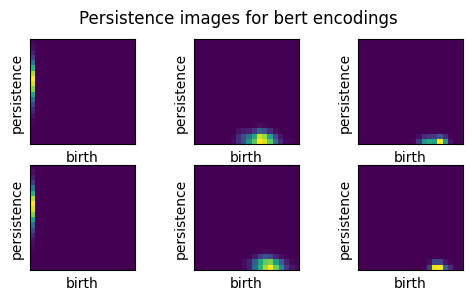

H0: Linear regression classification score was 0.8382352941176471
H0: Binning classification score was 0.7352941176470589
H1: Linear regression classification score was 0.47058823529411764
H1: Binning classification score was 0.5441176470588235
H2: Linear regression classification score was 0.47058823529411764
H2: Binning classification score was 0.47058823529411764
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
ai mixed embeddings with alpha=0.3
|H0|: 8.645 |H1|: 1.025 |H2|: 0.045
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
human mixed embeddings with alpha=0.3
|H0|: 8.655 |H1|: 1.205 |H2|: 0.075


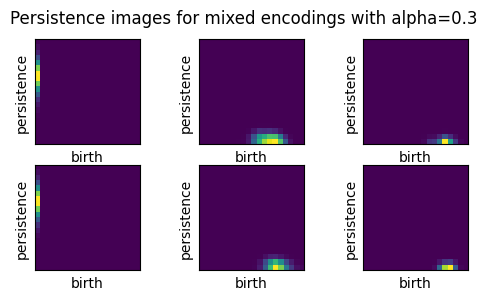

H0: Linear regression classification score was 0.78125
H0: Binning classification score was 0.7
H1: Linear regression classification score was 0.4666666666666667
H1: Binning classification score was 0.6666666666666666
H2: Linear regression classification score was 0.6
H2: Binning classification score was 0.8


In [ ]:
# testing
evaluation('bert', time_skeleton=False, with_smoothing=False, num_abstracts=200)
evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.3, num_abstracts=200)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


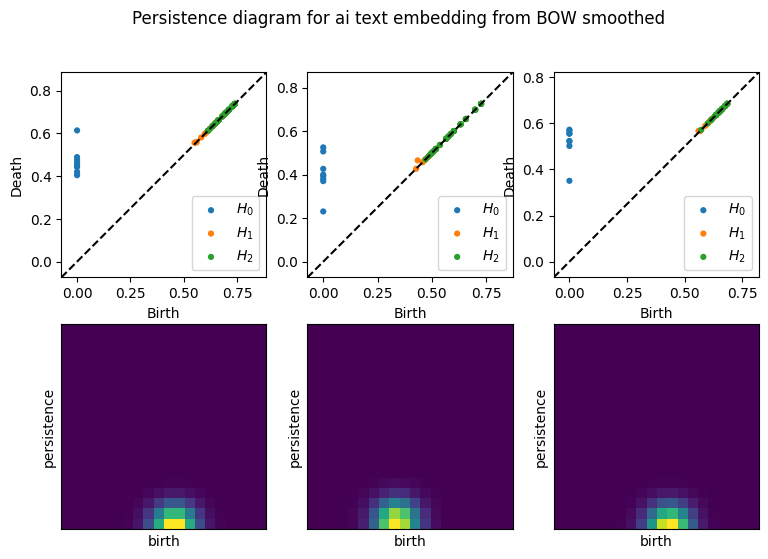

|H0|: 9.0 |H1|: 1.0 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


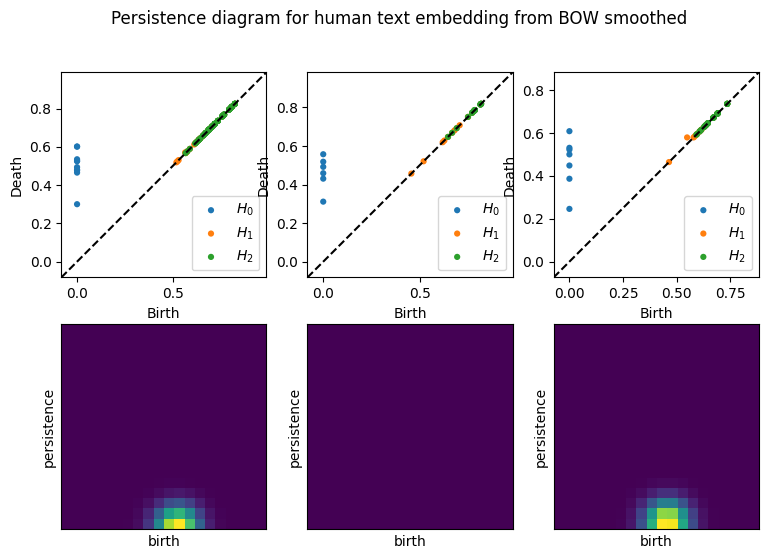

|H0|: 8.666666666666666 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


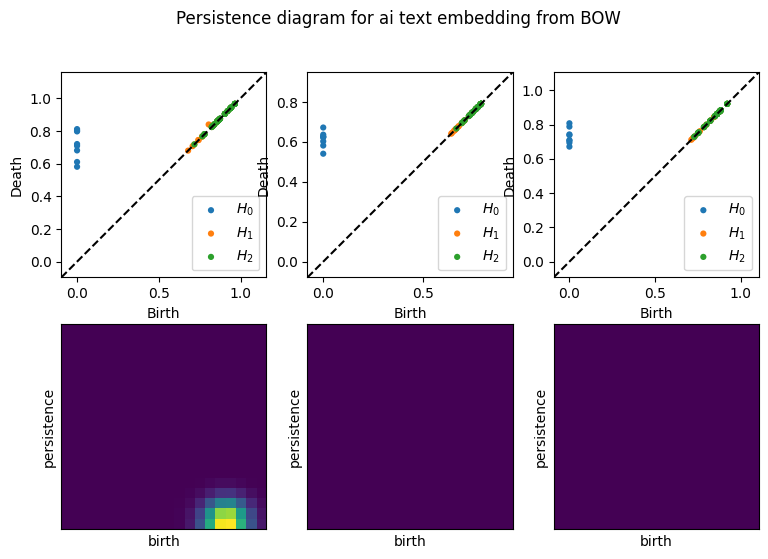

|H0|: 9.0 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


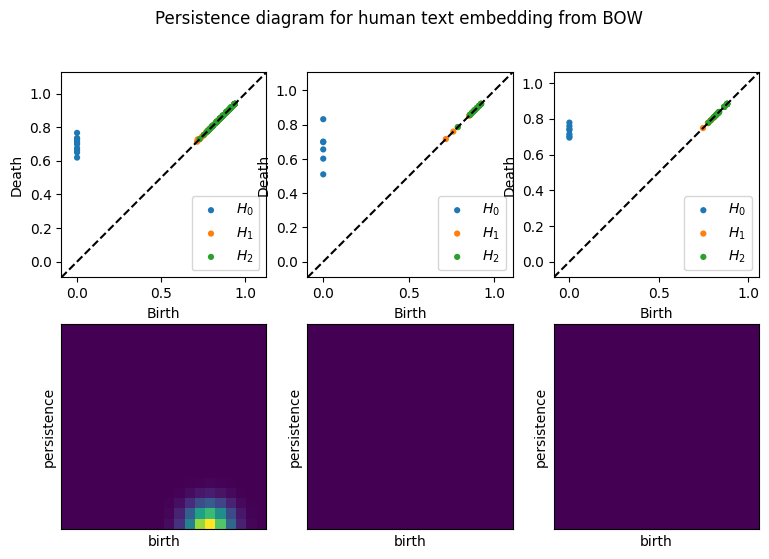

|H0|: 8.666666666666666 |H1|: 0.3333333333333333 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


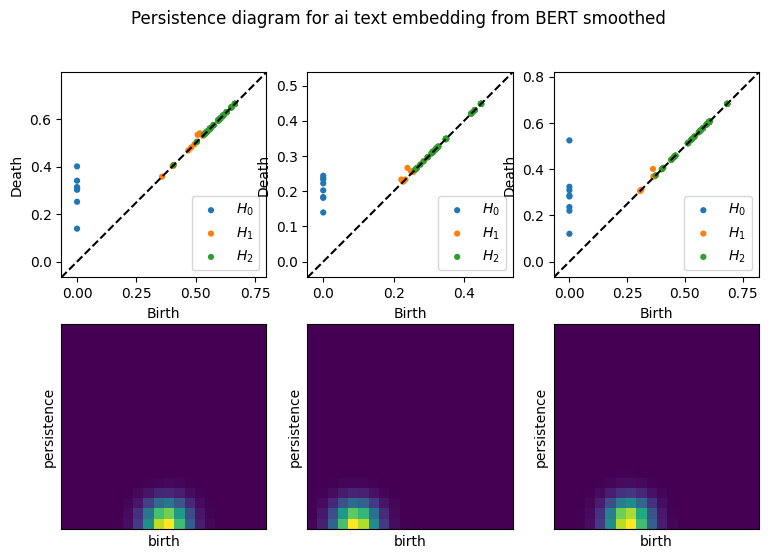

|H0|: 9.0 |H1|: 2.3333333333333335 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


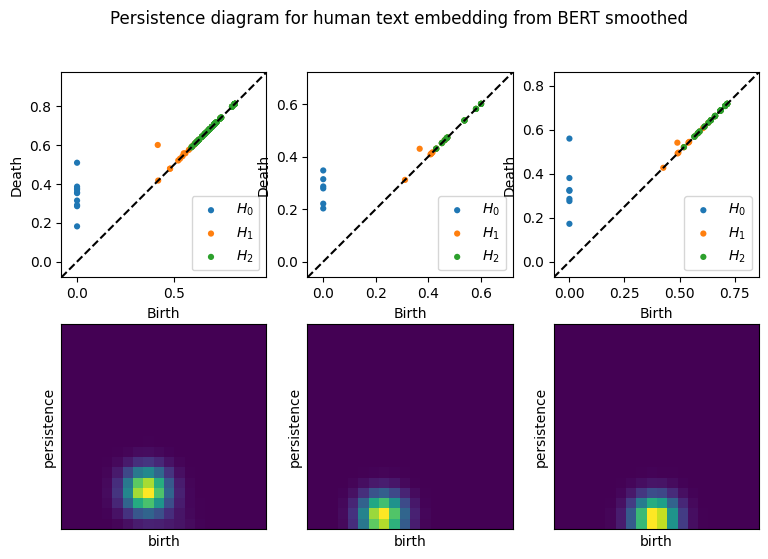

|H0|: 8.666666666666666 |H1|: 1.3333333333333333 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


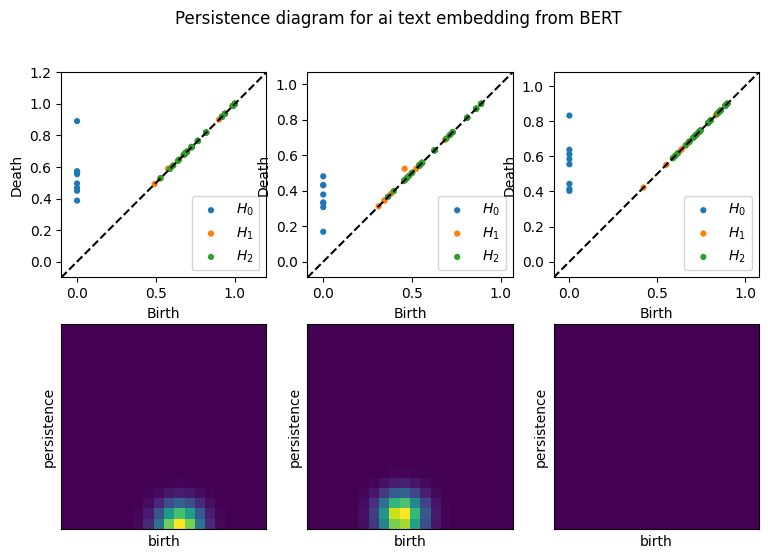

|H0|: 9.0 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


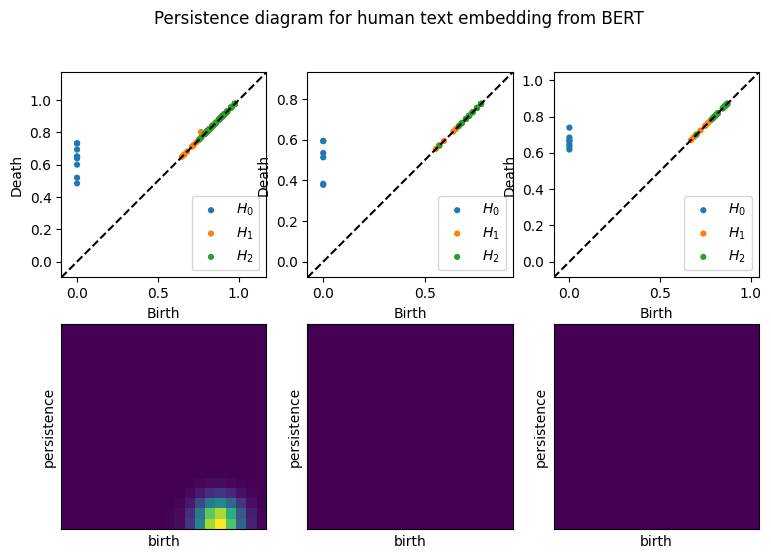

|H0|: 8.666666666666666 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


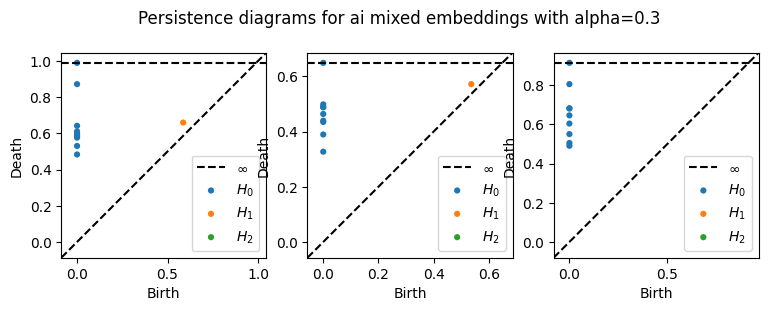

|H0|: 9.0 |H1|: 0.6666666666666666 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


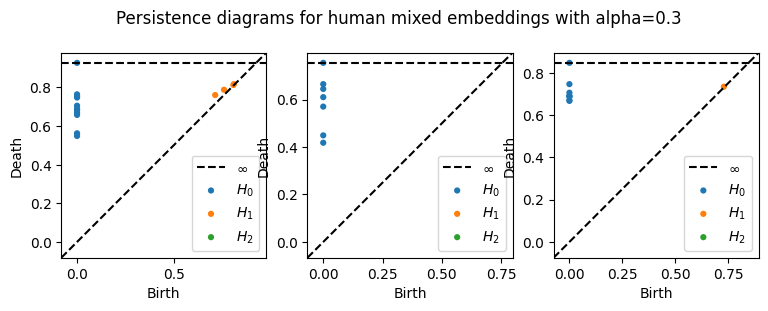

|H0|: 8.666666666666666 |H1|: 1.6666666666666667 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


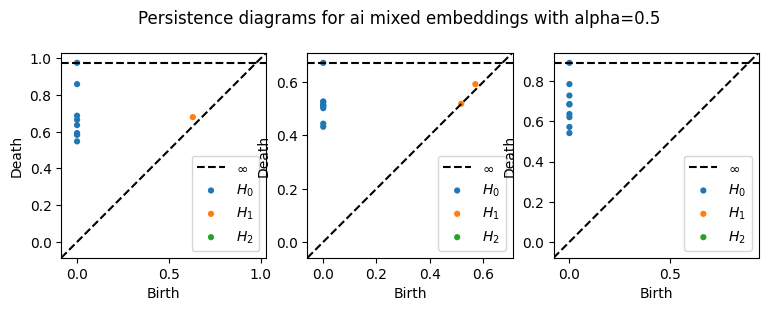

|H0|: 9.0 |H1|: 1.0 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


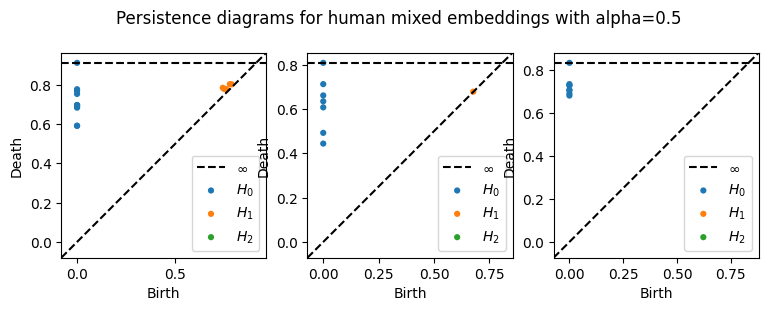

|H0|: 8.666666666666666 |H1|: 2.0 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


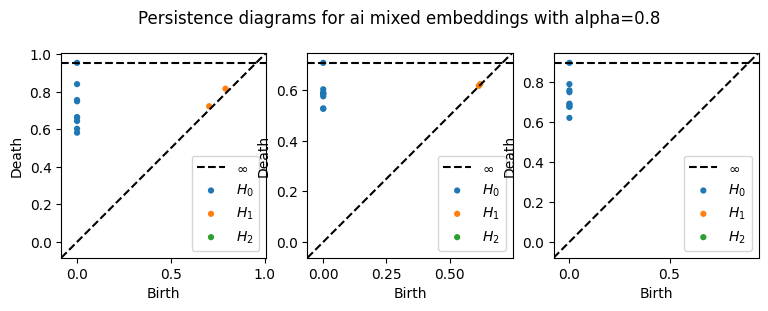

|H0|: 9.0 |H1|: 1.3333333333333333 |H2|: 0.0
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


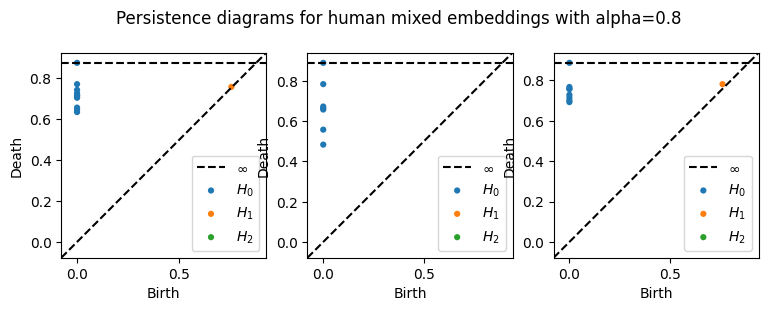

|H0|: 8.666666666666666 |H1|: 0.6666666666666666 |H2|: 0.0


In [48]:
# Prints out sample persistence diagrams for a variety of combinations
for encoding_type in ('bow', 'bert'):
  for with_smoothing in (True, False):
    for abstract_type in ('ai', 'human'):
      run_evaluation(abstract_type, encoding_type, time_skeleton=False, with_smoothing=with_smoothing, graph=True)

for alpha in (0.3, 0.5, 0.8):
  for abstract_type in ('ai', 'human'):
    run_mixed_encoding_evaluation(abstract_type, alpha, graph=True)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BOW smoothed
|H0|: 7.861 |H1|: 0.982 |H2|: 0.021
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BOW smoothed
|H0|: 7.557 |H1|: 0.874 |H2|: 0.019


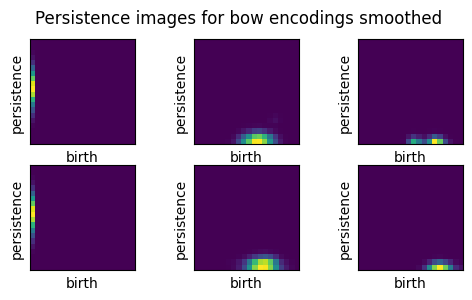

H0: Linear regression classification score was 0.5688622754491018
H0: Binning classification score was 0.5494011976047904
H1: Linear regression classification score was 0.5329341317365269
H1: Binning classification score was 0.5329341317365269
H2: Linear regression classification score was 0.5359281437125748
H2: Binning classification score was 0.47005988023952094

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BOW
|H0|: 7.861 |H1|: 0.869 |H2|: 0.043
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BOW
|H0|: 7.555 |H1|: 0.883 |H2|: 0.057


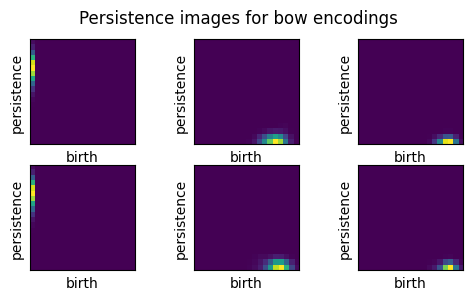

H0: Linear regression classification score was 0.6497005988023952
H0: Binning classification score was 0.6077844311377245
H1: Linear regression classification score was 0.5359281437125748
H1: Binning classification score was 0.5359281437125748
H2: Linear regression classification score was 0.5359281437125748
H2: Binning classification score was 0.46706586826347307

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BERT smoothed
|H0|: 7.861 |H1|: 1.102 |H2|: 0.016
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BERT smoothed
|H0|: 7.558 |H1|: 0.992 |H2|: 0.032


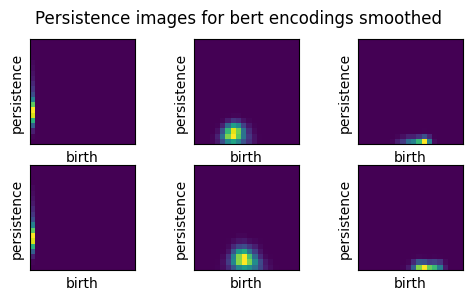

H0: Linear regression classification score was 0.7485029940119761
H0: Binning classification score was 0.6616766467065869
H1: Linear regression classification score was 0.6107784431137725
H1: Binning classification score was 0.7035928143712575
H2: Linear regression classification score was 0.5359281437125748
H2: Binning classification score was 0.4550898203592814

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BERT
|H0|: 7.86 |H1|: 0.814 |H2|: 0.032
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BERT
|H0|: 7.555 |H1|: 1.086 |H2|: 0.053


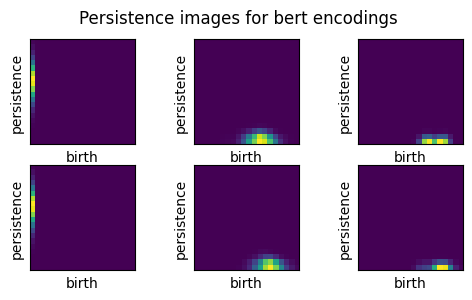

H0: Linear regression classification score was 0.781437125748503
H0: Binning classification score was 0.7170658682634731
H1: Linear regression classification score was 0.5479041916167665
H1: Binning classification score was 0.5658682634730539
H2: Linear regression classification score was 0.5359281437125748
H2: Binning classification score was 0.46407185628742514

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
ai mixed embeddings with alpha=0.3
|H0|: 8.358 |H1|: 0.847 |H2|: 0.026
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
human mixed embeddings with alpha=0.3
|H0|: 8.184 |H1|: 1.06 |H2|: 0.062


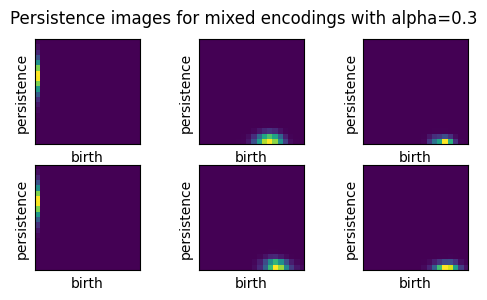

H0: Linear regression classification score was 0.705
H0: Binning classification score was 0.665
H1: Linear regression classification score was 0.5392156862745098
H1: Binning classification score was 0.7009803921568627
H2: Linear regression classification score was 0.6875
H2: Binning classification score was 0.5

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
ai mixed embeddings with alpha=0.5
|H0|: 8.358 |H1|: 0.882 |H2|: 0.042
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
human mixed embeddings with alpha=0.5
|H0|: 8.184 |H1|: 1.038 |H2|: 0.055


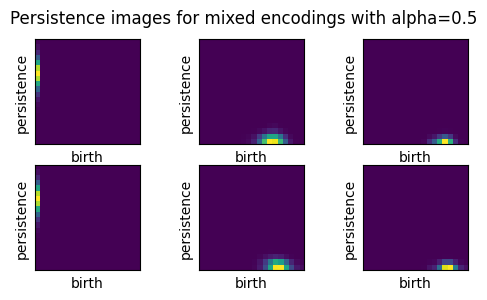

H0: Linear regression classification score was 0.67625
H0: Binning classification score was 0.6725
H1: Linear regression classification score was 0.5121951219512195
H1: Binning classification score was 0.697560975609756
H2: Linear regression classification score was 0.6111111111111112
H2: Binning classification score was 0.7777777777777778

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
ai mixed embeddings with alpha=0.8
|H0|: 8.358 |H1|: 0.961 |H2|: 0.05
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
human mixed embeddings with alpha=0.8
|H0|: 8.184 |H1|: 0.976 |H2|: 0.059


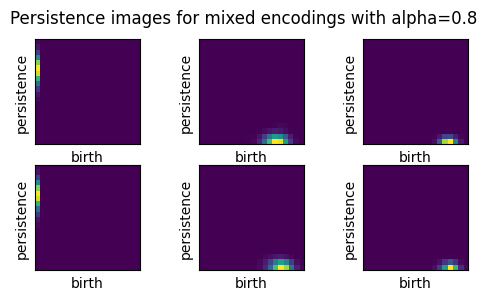

H0: Linear regression classification score was 0.62125
H0: Binning classification score was 0.59125
H1: Linear regression classification score was 0.49748743718592964
H1: Binning classification score was 0.628140703517588
H2: Linear regression classification score was 0.5
H2: Binning classification score was 0.6666666666666666



In [ ]:
for encoding_type in ('bow', 'bert'):
  for with_smoothing in (True, False):
    evaluation(encoding_type, time_skeleton=False, with_smoothing=with_smoothing, num_abstracts=1000)
    print("")
# running without BOW for speed
# for with_smoothing in (True, False):
#   evaluation('bert', time_skeleton=False, with_smoothing=with_smoothing, num_abstracts=500)
#   print("")

for alpha in (0.3, 0.5, 0.8):
  evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=alpha, num_abstracts=1000)
  print("")

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BOW
|H0|: 7.96 |H1|: 0.95 |H2|: 0.01
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BOW
|H0|: 8.04 |H1|: 1.07 |H2|: 0.08


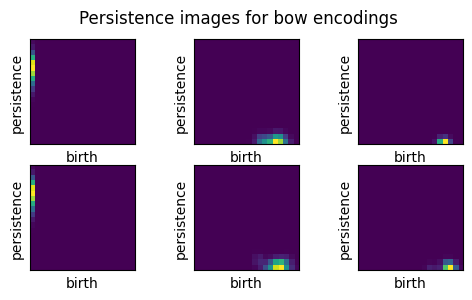

H0: Linear regression classification score was 0.5522388059701493
H0: Binning classification score was 0.6567164179104478
H1: Linear regression classification score was 0.4117647058823529
H1: Binning classification score was 0.47058823529411764
H2: Linear regression classification score was 0.4117647058823529
H2: Binning classification score was 0.4117647058823529

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BOW with time skeleton


<ipython-input-104-a90b5ea24d10>:353: RuntimeWarning:

invalid value encountered in divide



|H0|: 0.83 |H1|: 2.82 |H2|: 0.12
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BOW with time skeleton
|H0|: 0.84 |H1|: 2.79 |H2|: 0.13


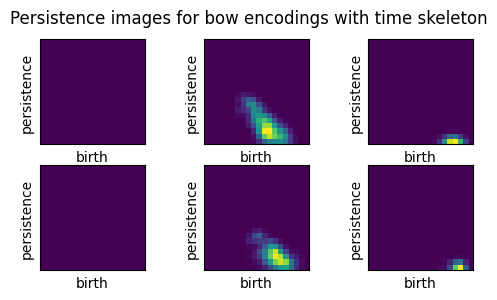

H0: Linear regression classification score was 0.47761194029850745
H0: Binning classification score was 0.5223880597014925
H1: Linear regression classification score was 0.4117647058823529
H1: Binning classification score was 0.6470588235294118
H2: Linear regression classification score was 0.4117647058823529
H2: Binning classification score was 0.47058823529411764

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
ai text embedding from BERT


<ipython-input-104-a90b5ea24d10>:290: RuntimeWarning:

invalid value encountered in divide

<ipython-input-104-a90b5ea24d10>:292: RuntimeWarning:

invalid value encountered in divide



|H0|: 7.96 |H1|: 0.86 |H2|: 0.08
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
human text embedding from BERT
|H0|: 8.04 |H1|: 1.24 |H2|: 0.03


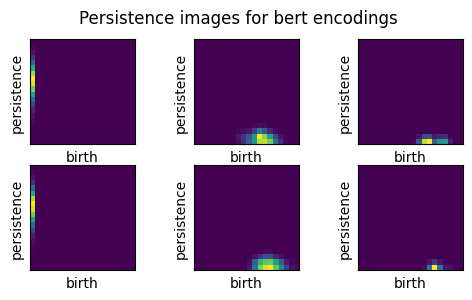

H0: Linear regression classification score was 0.7910447761194029
H0: Binning classification score was 0.7313432835820896
H1: Linear regression classification score was 0.4117647058823529
H1: Binning classification score was 0.5294117647058824
H2: Linear regression classification score was 0.4117647058823529
H2: Binning classification score was 0.4117647058823529


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
ai mixed embeddings with alpha=0.5
|H0|: 8.57 |H1|: 1.17 |H2|: 0.06
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
human mixed embeddings with alpha=0.5
|H0|: 8.59 |H1|: 1.25 |H2|: 0.08


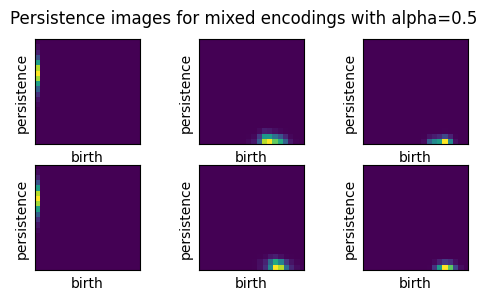

H0: Linear regression classification score was 0.65
H0: Binning classification score was 0.625
H1: Linear regression classification score was 0.34782608695652173
H1: Binning classification score was 0.6521739130434783
H2: Linear regression classification score was 0.3333333333333333
H2: Binning classification score was 0.3333333333333333




In [ ]:
# Testing only
evaluation('bow', time_skeleton=False, with_smoothing=False, num_abstracts=100)
print("")
evaluation('bow', time_skeleton=True, with_smoothing=False, num_abstracts=100)
print("")
evaluation('bert', time_skeleton=False, with_smoothing=False, num_abstracts=100)
print("")
#evaluation('bert', time_skeleton=True, with_smoothing=False, num_abstracts=100)
print("")
evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.5, num_abstracts=100)
print("")
#evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.3, num_abstracts=100)
print("")
#evaluation('mixed', time_skeleton=False, with_smoothing=False, alpha=0.8, num_abstracts=100)